<a href="https://colab.research.google.com/github/PatrickParsa/Malaria-Detection-CNN/blob/main/Malaria%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Malaria Detection**

###<b> Mounting the Drive

In [1]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###<b>Loading libraries</b>

In [3]:
#Importing libraries required to load the data

import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, LeakyReLU, GlobalAvgPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

### <b>Let us load the data</b>

**Note:** 
- You must download the dataset from the link provided on Olympus and upload the same on your Google drive before executing the code in the next cell.
- In case of any error, please make sure that the path of the file is correct as the path may be different for you.

In [4]:
#Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/CNN Project Malaria Detection /cell_images.zip'

#The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

The files have been extracted to the local session of Google Colab. The extracted folder would have the following structure:

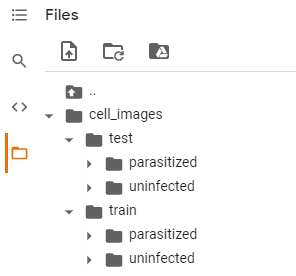

The extracted folder has different folders for train and test data which further contains the different sizes of images for parasitized and uninfected cells within the respective folder name. 

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model. 

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [5]:
#Storing the path of the extracted "train" folder 
train_dir = '/content/cell_images/train'

#Size of image so that each image has the same size
SIZE = 64

#Empty list to store the training images after they are converted to NumPy arrays
train_images = []

#Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

In [6]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "train" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(train_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(train_dir + folder_name + image_name)

            #Resizing each image to (224,224)
            image = image.resize((SIZE, SIZE))

            #Converting images to arrays and appending that array to the empty list defined above
            train_images.append(np.array(image))

            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                train_labels.append(1)
            else:
                train_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [7]:
#Storing the path of the extracted "test" folder 
test_dir = '/content/cell_images/test'

#Size of image so that each image has the same size (it must be same as the train image size)
SIZE = 64

#Empty list to store the testing images after they are converted to NumPy arrays
test_images = []

#Empty list to store the testing labels (0 - uninfected, 1 - parasitized)
test_labels = []

In [8]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "test" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(test_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(test_dir + folder_name + image_name)
            
            #Resizing each image to (128,128)
            image = image.resize((SIZE, SIZE))
            
            #Converting images to arrays and appending that array to the empty list defined above
            test_images.append(np.array(image))
            
            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                test_labels.append(1)
            else:
                test_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

###<b>Normalize the images

In [9]:
# try to normalize the train and test images by dividing it by 255 and convert them to float32 using astype function
og_train_images = train_images
og_test_images = test_images

train_images = (train_images/255).astype('float32')
test_images = (test_images/255).astype('float32')

As we have done our preprocessing required and performed some EDA to gain some insights in our Milestone-1 so now we will try to build our model and try evaluating its performance.

###<B>One Hot Encoding on the train and test labels

In [10]:
# Encoding Train Labels
train_labels=to_categorical(train_labels,2)
# Similarly let us try to encode test labels
test_labels=to_categorical(test_labels,2)

### **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

####<b> Importing the required libraries

In [11]:
#Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Building the model

In [12]:

#creating sequential model
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4

####<b> Compiling the model

In [13]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<b> Using Callbacks 

In [14]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b> Fit and train our Model

In [15]:
#Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
history=model.fit(train_images,train_labels,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
624/624 [==============================] - 38s 12ms/step - loss: 0.4365 - accuracy: 0.7888 - val_loss: 0.4076 - val_accuracy: 0.9067
Epoch 2/20
624/624 [==============================] - 7s 11ms/step - loss: 0.1808 - accuracy: 0.9375 - val_loss: 0.1919 - val_accuracy: 0.9641
Epoch 3/20
624/624 [==============================] - 7s 11ms/step - loss: 0.1607 - accuracy: 0.9439 - val_loss: 0.1811 - val_accuracy: 0.9511
Epoch 4/20
624/624 [==============================] - 7s 12ms/step - loss: 0.1568 - accuracy: 0.9468 - val_loss: 0.1524 - val_accuracy: 0.9621
Epoch 5/20
624/624 [==============================] - 7s 11ms/step - loss: 0.1488 - accuracy: 0.9510 - val_loss: 0.1792 - val_accuracy: 0.9579
Epoch 6/20
624/624 [==============================] - 7s 11ms/step - loss: 0.1399 - accuracy: 0.9539 - val_loss: 0.1639 - val_accuracy: 0.9563


####<b> Evaluating the model on test data

In [16]:
accuracy = model.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 1s 6ms/step - loss: 0.1547 - accuracy: 0.9473

 Test_Accuracy:- 0.9473077058792114


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1300
           1       0.95      0.94      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



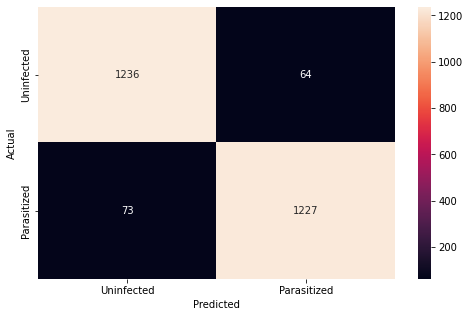

In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b>Plotting the train and validation curves

In [18]:
# function to plot train and validation accuracy 
def plot_accuracy(history):
    N = len(history.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

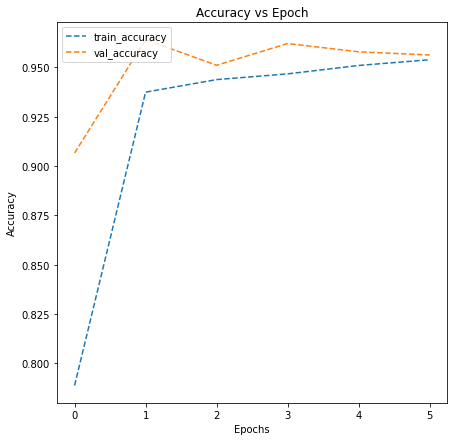

In [19]:
plot_accuracy(history)



* Here we can clearly observe that the training and valiation accuracy are increasing 
* And we can also notice that validation accuracy is slightly higher than the train accuracy

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

###<b> Model 1
####<b> Trying to improve the performance of our model by adding new layers


In [20]:
#Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Building the Model

In [21]:
#creating sequential model
model1=Sequential()
model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu")) #adding a 4th layer
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))


model1.add(Flatten())

model1.add(Dense(512,activation="relu"))
model1.add(Dropout(0.4))
model1.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model1.summary()

# Build the model here



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4

####<b> Compiling the model

In [22]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<b> Using Callbacks

In [23]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fit and Train the model

In [24]:
history1=model1.fit(train_images,train_labels,batch_size=32,callbacks=callbacks,  validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
624/624 [==============================] - 8s 12ms/step - loss: 0.3664 - accuracy: 0.8267 - val_loss: 0.1919 - val_accuracy: 0.9613
Epoch 2/20
624/624 [==============================] - 7s 11ms/step - loss: 0.1682 - accuracy: 0.9452 - val_loss: 0.1906 - val_accuracy: 0.9597
Epoch 3/20
624/624 [==============================] - 7s 12ms/step - loss: 0.1574 - accuracy: 0.9486 - val_loss: 0.1012 - val_accuracy: 0.9690
Epoch 4/20
624/624 [==============================] - 7s 11ms/step - loss: 0.1513 - accuracy: 0.9507 - val_loss: 0.1335 - val_accuracy: 0.9651
Epoch 5/20
624/624 [==============================] - 7s 11ms/step - loss: 0.1449 - accuracy: 0.9537 - val_loss: 0.1242 - val_accuracy: 0.9671


####<b> Evaluating the model

In [25]:
accuracy1 = model1.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy1[1])

82/82 [==============================] - 1s 6ms/step - loss: 0.1524 - accuracy: 0.9542

 Test_Accuracy:- 0.954230785369873


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1300
           1       0.97      0.94      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



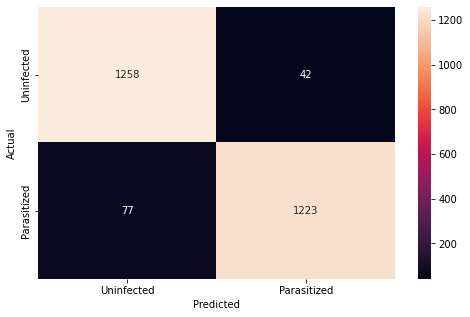

In [91]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred1 = model1.predict(test_images)
pred1 = np.argmax(pred1,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred1))

#Plotting the heatmap using confusion matrix
cm1 = confusion_matrix(y_true,pred1)
plt.figure(figsize=(8,5))
sns.heatmap(cm1, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b> Plotting the Train and validation curves

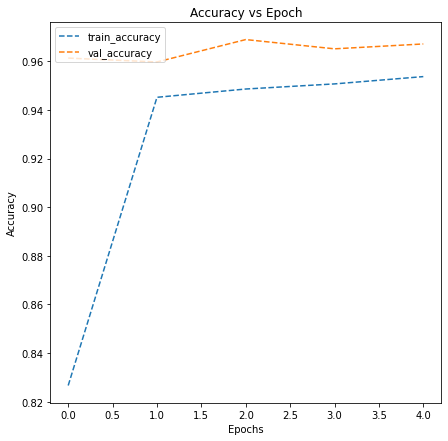

In [27]:
plot_accuracy(history1)

####<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

###<b> Model 2 with Batch Normalization

In [28]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Building the Model

In [29]:
model2 = Sequential()
model2.add(Conv2D(32, (3,3), input_shape=(64, 64, 3), padding='same'))
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.2))
model2.add(Conv2D(filters=32,kernel_size=2,padding="same"))
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size=2))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Conv2D(filters=32,kernel_size=2,padding="same"))
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size=2))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Conv2D(filters=32,kernel_size=2,padding="same"))
model2.add(LeakyReLU(alpha=0.1)) 
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.2))


model2.add(Flatten())

model2.add(Dense(512))
model2.add(Dropout(0.4))



model2.add(Dense(2, activation='softmax'))

adam = optimizers.Adam(learning_rate=0.001)

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4128      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0

####<b>Compiling the model

In [30]:
model2.compile(loss="binary_crossentropy", optimizer=adam, metrics = ['accuracy'])

<b> Using callbacks

In [31]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fit and train the model

In [32]:
history2 = model2.fit(train_images,train_labels,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
624/624 [==============================] - 10s 13ms/step - loss: 0.5083 - accuracy: 0.7724 - val_loss: 0.2242 - val_accuracy: 0.9653
Epoch 2/20
624/624 [==============================] - 8s 13ms/step - loss: 0.2107 - accuracy: 0.9333 - val_loss: 0.1864 - val_accuracy: 0.9786
Epoch 3/20
624/624 [==============================] - 8s 13ms/step - loss: 0.1865 - accuracy: 0.9397 - val_loss: 0.1496 - val_accuracy: 0.9840
Epoch 4/20
624/624 [==============================] - 8s 13ms/step - loss: 0.1764 - accuracy: 0.9435 - val_loss: 0.1580 - val_accuracy: 0.9796
Epoch 5/20
624/624 [==============================] - 8s 13ms/step - loss: 0.1684 - accuracy: 0.9445 - val_loss: 0.1168 - val_accuracy: 0.9796
Epoch 6/20
624/624 [==============================] - 8s 13ms/step - loss: 0.1655 - accuracy: 0.9455 - val_loss: 0.2094 - val_accuracy: 0.9665
Epoch 7/20
624/624 [==============================] - 8s 13ms/step - loss: 0.1607 - accuracy: 0.9470 - val_loss: 0.2099 - val_accuracy: 0.970

<b>Plotting the train and validation accuracy

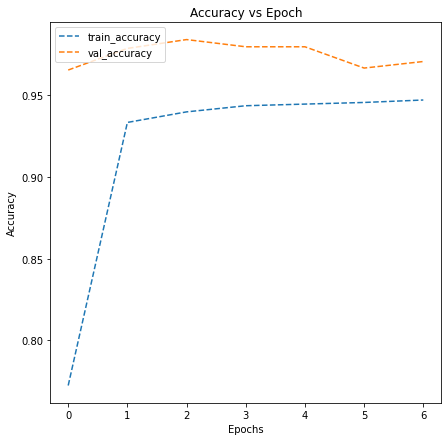

In [33]:
# plotting the accuracies
plot_accuracy(history2)

####<b>Evaluating the model

In [34]:
# Evaluate the model to calculate the accuracy
accuracy2 = model2.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy2[1])

82/82 [==============================] - 1s 7ms/step - loss: 0.1666 - accuracy: 0.9481

 Test_Accuracy:- 0.9480769038200378


#####<b>Observations and insights: 

Attempted several different layers of batch normalization and saw strong performance however there was no significant improvement over the previous model. It is worth mentioning though that we did see 5 fewer misclassifications of uninfected on cases that were actually infected, which is what we are aiming to minimize. 

<b> Generate the classification report and confusion matrix 

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1300
           1       0.96      0.93      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



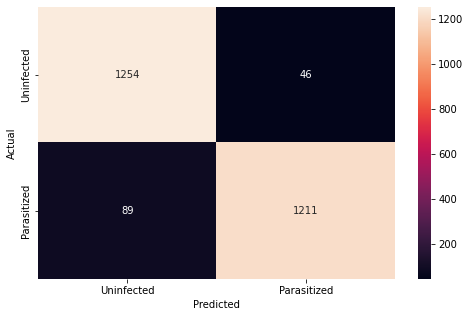

In [35]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred2 = model2.predict(test_images)
pred2 = np.argmax(pred2,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)
#Printing the classification report
print(classification_report(y_true,pred2))

#Plotting the heatmap using confusion matrix
cm2 = confusion_matrix(y_true,pred2)
plt.figure(figsize=(8,5))
sns.heatmap(cm2, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

####**Think About It :**<br>

* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





###<b>Model 3 with Data Augmentation

In [36]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Using image data generator

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, train_size=0.2, random_state=42)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using ImageDataGenerator to generate images

train_datagen = ImageDataGenerator(horizontal_flip=True, 
                                  zoom_range = 0.5, rotation_range=30)
val_datagen  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = X_train, y = y_train, batch_size=64, seed=42, shuffle=True)     

# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow(x= X_val, y = y_val, batch_size=64, seed=42, shuffle=True)

####**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.



####<B>Visualizing Augmented images

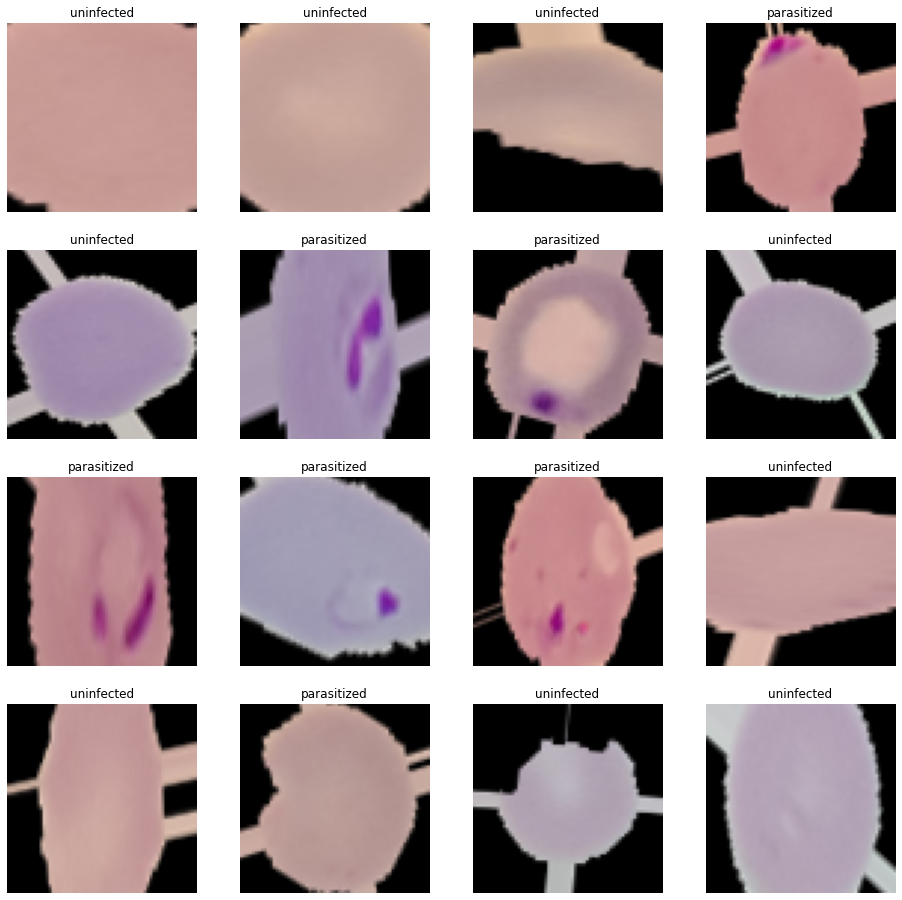

In [38]:
#Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

#Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))
fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    if label[1] == 1: 
        ax.set_title('parasitized')
    else:
        ax.set_title('uninfected')
    ax.axis('off')

#####<b>Observations and insights:

* Our augmented images provide several transformations including zoom, rotation, and flip. The goal here is to see if these transformations lead to a stronger model that can better generalize and learn more thoroughly how to spot infected cells. 

####<b>Building the Model

In [39]:
model3 = Sequential()

model3.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))
model3.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))
model3.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))
model3.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu")) 
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))

model3.add(Flatten())

model3.add(Dense(512,activation="relu"))
model3.add(Dropout(0.4))
model3.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
adam = optimizers.Adam(learning_rate=0.001)

model3.compile(loss='binary_crossentropy', optimizer=adam, metrics = ['accuracy'])
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4

<b>Using Callbacks

In [40]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b> Fit and Train the model

In [41]:
history3 = model3.fit(train_generator, 
                                  validation_data=val_generator,
                                  batch_size=32,callbacks=callbacks,
                                  epochs=20,verbose=1)

Epoch 1/20
78/78 [==============================] - 10s 116ms/step - loss: 0.6870 - accuracy: 0.5460 - val_loss: 0.6771 - val_accuracy: 0.5822
Epoch 2/20
78/78 [==============================] - 9s 111ms/step - loss: 0.6624 - accuracy: 0.6073 - val_loss: 0.6668 - val_accuracy: 0.6500
Epoch 3/20
78/78 [==============================] - 9s 113ms/step - loss: 0.6221 - accuracy: 0.6700 - val_loss: 0.5442 - val_accuracy: 0.7602
Epoch 4/20
78/78 [==============================] - 9s 113ms/step - loss: 0.4792 - accuracy: 0.7898 - val_loss: 0.2689 - val_accuracy: 0.9277
Epoch 5/20
78/78 [==============================] - 9s 113ms/step - loss: 0.2905 - accuracy: 0.8924 - val_loss: 0.2106 - val_accuracy: 0.9444
Epoch 6/20
78/78 [==============================] - 9s 115ms/step - loss: 0.2818 - accuracy: 0.8998 - val_loss: 0.1718 - val_accuracy: 0.9526
Epoch 7/20
78/78 [==============================] - 9s 112ms/step - loss: 0.2710 - accuracy: 0.9010 - val_loss: 0.1719 - val_accuracy: 0.9544
Epoch

####<B>Evaluating the model

<b>Plot the train and validation accuracy

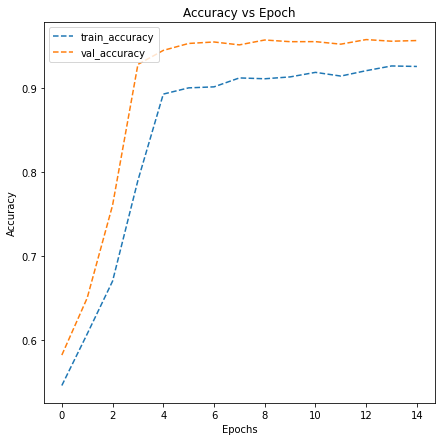

In [42]:
# plotting the accuracies
plot_accuracy(history3)

In [43]:
# Evaluating the model on test data
accuracy3 = model3.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy3[1])

82/82 [==============================] - 1s 5ms/step - loss: 0.1679 - accuracy: 0.9523

 Test_Accuracy:- 0.9523077011108398


<B>Plotting the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1300
           1       0.97      0.93      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



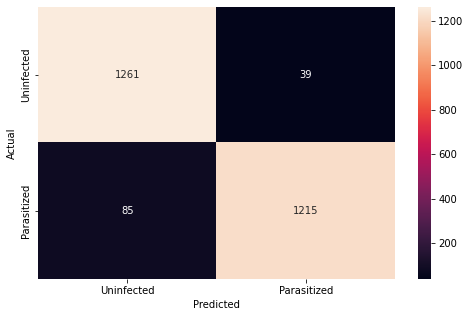

In [44]:
pred3 = model3.predict(test_images)
pred3 = np.argmax(pred3,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred3))

#Plotting the heatmap using confusion matrix
cm3 = confusion_matrix(y_true,pred3)
plt.figure(figsize=(8,5))
sns.heatmap(cm3, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b> Now let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG16)**

In [45]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [46]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

vgg = VGG16(include_top=False, weights='imagenet', input_shape=(64,64,3))
vgg.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

In [47]:
transfer_layer = vgg.get_layer('block5_pool')
vgg.trainable=False

# Add classification layers on top of it  
 
x = Flatten()(transfer_layer.output) #Flatten the output from the 3rd block of the VGG16 model
x = Dense(256, activation='relu')(x)

# Similarly add a dense layer with 128 neurons
x = Dropout(0.3)(x)

# Add a dense layer with 64 neurons

x = BatchNormalization()(x)
pred = Dense(2, activation='softmax')(x)

model4 = Model(vgg.input, pred) #Initializing the model

####<b>Compiling the model

In [48]:
model4.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

<b> using callbacks

In [49]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fit and Train the model

In [50]:
#Fitting the model and running the model for 10 epochs
history4 = model4.fit(
            train_images, train_labels,
            epochs=10,
            callbacks=callbacks,
            batch_size=32,
            validation_split=0.2,
            verbose=1
)

Epoch 1/10
624/624 [==============================] - 28s 41ms/step - loss: 0.2538 - accuracy: 0.8995 - val_loss: 0.1490 - val_accuracy: 0.9545
Epoch 2/10
624/624 [==============================] - 24s 39ms/step - loss: 0.2108 - accuracy: 0.9186 - val_loss: 0.2886 - val_accuracy: 0.8862
Epoch 3/10
624/624 [==============================] - 24s 39ms/step - loss: 0.2012 - accuracy: 0.9220 - val_loss: 0.1217 - val_accuracy: 0.9635
Epoch 4/10
624/624 [==============================] - 24s 39ms/step - loss: 0.1994 - accuracy: 0.9233 - val_loss: 0.1950 - val_accuracy: 0.9239
Epoch 5/10
624/624 [==============================] - 26s 41ms/step - loss: 0.1878 - accuracy: 0.9282 - val_loss: 0.1898 - val_accuracy: 0.9405


<b>Plot the train and validation accuracy

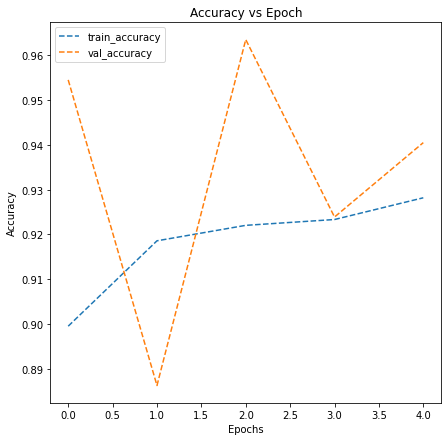

In [51]:
# plotting the accuracies
plot_accuracy(history4)

#####**Observations and insights:**

We can see that this pre-trained model performed worse than our previous models 

* The strong difference in the validation and train curves could signify underfitting, meaning that our model isn't complex enough to strongly perform on the training data. 

####<b> Evaluating the model

In [52]:
accuracy4 = model4.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy4[1])


82/82 [==============================] - 3s 38ms/step - loss: 0.1800 - accuracy: 0.9342

 Test_Accuracy:- 0.9342307448387146


<b>Plotting the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1300
           1       0.94      0.93      0.93      1300

    accuracy                           0.93      2600
   macro avg       0.93      0.93      0.93      2600
weighted avg       0.93      0.93      0.93      2600



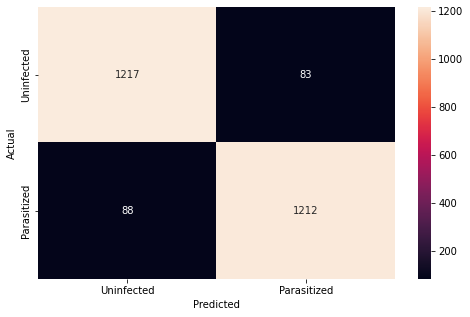

In [53]:
pred4 = model4.predict(test_images)
pred4 = np.argmax(pred4,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred4))

#Plotting the heatmap using confusion matrix
cm4 = confusion_matrix(y_true,pred4)
plt.figure(figsize=(8,5))
sns.heatmap(cm4, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

####<b>Think about it:</b>
*  What observations and insights can be drawn from the confusion matrix and classification report?
*  Choosw the model with the best accuracy scores from all the above models and save it as a final model.


## **Our best model is model1, and we will improve it by tuning it using Keras Tuner**

In [54]:
#Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [55]:
pip install keras-tuner --upgrade

     |████████████████████████████████| 98 kB 3.3 MB/s 


In [56]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import time


In [57]:
def build_model5(hp):

  model5=Sequential()
  model5.add(Conv2D(hp.Int('input_units',min_value = 32, max_value = 256, step = 32),kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
  model5.add(MaxPooling2D(pool_size=2))
  model5.add(Dropout(0.2))
  
  model5.add(Conv2D(hp.Int('input_units2',min_value = 32, max_value = 256, step = 32),kernel_size=2,padding="same",activation="relu"))
  model5.add(MaxPooling2D(pool_size=2))
  model5.add(Dropout(0.2))
  
  model5.add(Conv2D(hp.Int('input_units3',min_value = 32, max_value = 256, step = 32),kernel_size=2,padding="same",activation="relu"))
  model5.add(MaxPooling2D(pool_size=2))
  model5.add(Dropout(0.2))
  
  model5.add(Conv2D(hp.Int('input_units4',min_value = 32, max_value = 256, step = 32),kernel_size=2,padding="same",activation="relu")) #adding a 4th layer
  model5.add(MaxPooling2D(pool_size=2))
  model5.add(Dropout(0.2))


  model5.add(Flatten())

  model5.add(Dense(hp.Choice('Dense layer', [64,128,256,512,1024]),activation="relu"))
  model5.add(Dropout(0.4))
  model5.add(Dense(2,activation="softmax"))#2 represent output layer neurons
  model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
  
  return model5

In [58]:
tuner = RandomSearch(
    build_model5,
    objective="val_accuracy",
    max_trials=5,
     directory="sample_dir15",
    project_name="proj15",
)

In [59]:
tuner.search(x = train_images, 
             y = train_labels,
             epochs = 3,
             batch_size = 64,
             validation_data = (test_images,test_labels))
             
          

Trial 5 Complete [00h 00m 56s]
val_accuracy: 0.9515384435653687

Best val_accuracy So Far: 0.9557692408561707
Total elapsed time: 00h 10m 45s
INFO:tensorflow:Oracle triggered exit


In [60]:
tuner.results_summary()

Results summary
Results in sample_dir15/proj15
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
input_units: 224
input_units2: 64
input_units3: 160
input_units4: 64
Dense layer: 64
Score: 0.9557692408561707
Trial summary
Hyperparameters:
input_units: 160
input_units2: 160
input_units3: 128
input_units4: 224
Dense layer: 512
Score: 0.954230785369873
Trial summary
Hyperparameters:
input_units: 224
input_units2: 192
input_units3: 96
input_units4: 192
Dense layer: 256
Score: 0.9538461565971375
Trial summary
Hyperparameters:
input_units: 224
input_units2: 160
input_units3: 64
input_units4: 128
Dense layer: 1024
Score: 0.9538461565971375
Trial summary
Hyperparameters:
input_units: 64
input_units2: 192
input_units3: 32
input_units4: 224
Dense layer: 256
Score: 0.9515384435653687


## Now that we obtained the best hyperparameters for our model, we can rebuild our model using these parameters. 

In [61]:
model6=Sequential()
model6.add(Conv2D(filters=160,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3))) #altered the shape to allow grayscale images to be fed in, refer to grayscale section
model6.add(MaxPooling2D(pool_size=2))
model6.add(Dropout(0.2))
model6.add(Conv2D(filters=160,kernel_size=2,padding="same",activation="relu"))
model6.add(MaxPooling2D(pool_size=2))
model6.add(Dropout(0.2))
model6.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))
model6.add(MaxPooling2D(pool_size=2))
model6.add(Dropout(0.2))
model6.add(Conv2D(filters=224,kernel_size=2,padding="same",activation="relu")) 
model6.add(Dropout(0.2))


model6.add(Flatten())

model6.add(Dense(512,activation="relu"))
model6.add(Dropout(0.4))
model6.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model6.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 160)       2080      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 160)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 160)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 160)       102560    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 160)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 160)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)      

####<b> Compiling the model

In [62]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<b> Using Callbacks

In [63]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fit and Train the model

In [64]:
history6=model6.fit(train_images,train_labels,batch_size=32,callbacks=callbacks,  validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
624/624 [==============================] - 34s 52ms/step - loss: 0.5070 - accuracy: 0.7300 - val_loss: 0.1904 - val_accuracy: 0.9439
Epoch 2/20
624/624 [==============================] - 31s 50ms/step - loss: 0.1631 - accuracy: 0.9485 - val_loss: 0.1748 - val_accuracy: 0.9665
Epoch 3/20
624/624 [==============================] - 32s 51ms/step - loss: 0.1480 - accuracy: 0.9545 - val_loss: 0.1026 - val_accuracy: 0.9700
Epoch 4/20
624/624 [==============================] - 32s 51ms/step - loss: 0.1393 - accuracy: 0.9551 - val_loss: 0.1222 - val_accuracy: 0.9718
Epoch 5/20
624/624 [==============================] - 32s 51ms/step - loss: 0.1332 - accuracy: 0.9562 - val_loss: 0.1691 - val_accuracy: 0.9565


####<b> Evaluating the model

In [65]:
accuracy6 = model6.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy6[1])

82/82 [==============================] - 2s 19ms/step - loss: 0.1587 - accuracy: 0.9485

 Test_Accuracy:- 0.9484615325927734


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1300
           1       0.95      0.95      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



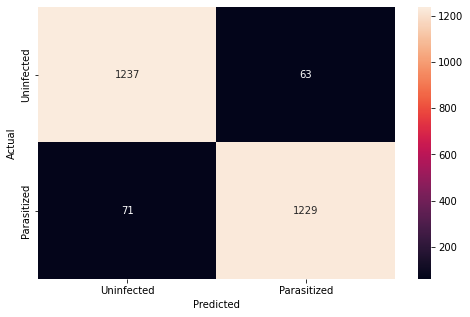

In [66]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred6 = model6.predict(test_images)
pred6 = np.argmax(pred6,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred6))

#Plotting the heatmap using confusion matrix
cm6 = confusion_matrix(y_true,pred6)
plt.figure(figsize=(8,5))
sns.heatmap(cm6, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b> Plotting the Train and validation curves

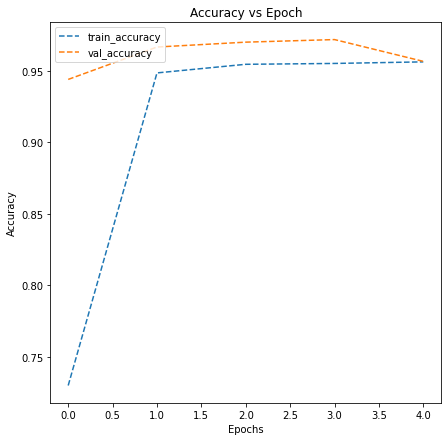

In [67]:
plot_accuracy(history6)

# Now best model with different pre-processing methods for our images to see if we get better results

In [68]:
 import matplotlib.cm as cm

Grayscale

In [69]:
import cv2
gray_train=[]   # to hold the gray image array
for i in np.arange(0,24958,1):
  a=cv2.cvtColor(train_images[i],cv2.COLOR_BGR2GRAY)
  gray_train.append(a)
gray_train=np.array(gray_train)

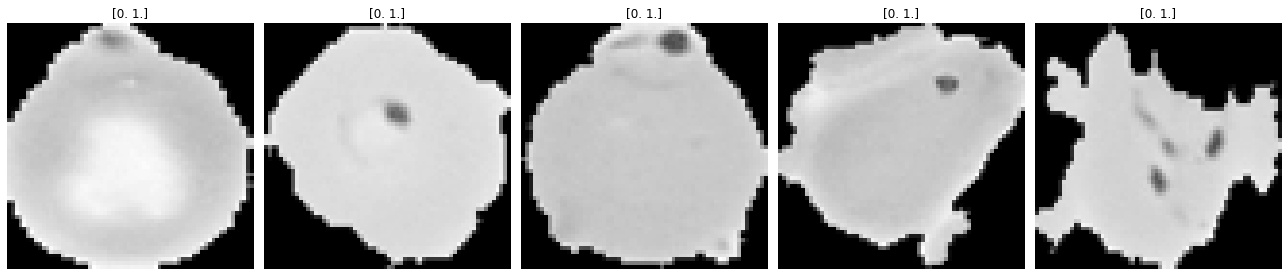

In [70]:
viewimage=np.random.randint(1,100,5)
fig,ax=plt.subplots(1,5,figsize=(18,18))
for t,i in zip(range(5),viewimage):
  Title=train_labels[i]
  ax[t].set_title(Title)
  ax[t].imshow(gray_train[i], cmap = cm.gray)
  ax[t].set_axis_off()
  fig.tight_layout()

In [73]:
import cv2
gray_test=[]   # to hold the gray image array
for i in np.arange(0,2600,1):
  a=cv2.cvtColor(test_images[i],cv2.COLOR_BGR2GRAY)
  gray_test.append(a)
gray_test=np.array(gray_test)

In [74]:
new_gray_train = gray_train.reshape(len(gray_train),64,64,1)
new_gray_test = gray_test.reshape(len(gray_test),64,64,1)

We now alter our final model to allow the (64,64,1) shape, and then we fit the model onto our new altered images.

In [75]:
model7=Sequential()
model7.add(Conv2D(filters=160,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,1))) #altered the shape to allow grayscale images to be fed in, refer to grayscale section
model7.add(MaxPooling2D(pool_size=2))
model7.add(Dropout(0.2))
model7.add(Conv2D(filters=160,kernel_size=2,padding="same",activation="relu"))
model7.add(MaxPooling2D(pool_size=2))
model7.add(Dropout(0.2))
model7.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))
model7.add(MaxPooling2D(pool_size=2))
model7.add(Dropout(0.2))
model7.add(Conv2D(filters=224,kernel_size=2,padding="same",activation="relu")) 
model7.add(Dropout(0.2))


model7.add(Flatten())

model7.add(Dense(512,activation="relu"))
model7.add(Dropout(0.4))
model7.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model7.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 64, 64, 160)       800       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 160)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 32, 160)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 160)       102560    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 160)       0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 16, 16, 160)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 128)      

In [76]:
model7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [77]:
history7=model7.fit(new_gray_train,train_labels,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
624/624 [==============================] - 34s 53ms/step - loss: 0.6566 - accuracy: 0.6303 - val_loss: 0.7135 - val_accuracy: 0.5992
Epoch 2/20
624/624 [==============================] - 33s 53ms/step - loss: 0.2717 - accuracy: 0.8890 - val_loss: 0.2466 - val_accuracy: 0.9409
Epoch 3/20
624/624 [==============================] - 33s 53ms/step - loss: 0.1615 - accuracy: 0.9457 - val_loss: 0.1164 - val_accuracy: 0.9659
Epoch 4/20
624/624 [==============================] - 33s 53ms/step - loss: 0.1520 - accuracy: 0.9479 - val_loss: 0.1126 - val_accuracy: 0.9704
Epoch 5/20
624/624 [==============================] - 33s 53ms/step - loss: 0.1489 - accuracy: 0.9484 - val_loss: 0.2451 - val_accuracy: 0.9377
Epoch 6/20
624/624 [==============================] - 33s 53ms/step - loss: 0.1466 - accuracy: 0.9495 - val_loss: 0.1867 - val_accuracy: 0.9543


In [78]:
accuracy7 = model7.evaluate(new_gray_test, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy7[1])

82/82 [==============================] - 2s 19ms/step - loss: 0.1654 - accuracy: 0.9481

 Test_Accuracy:- 0.9480769038200378


              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1300
           1       0.95      0.95      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



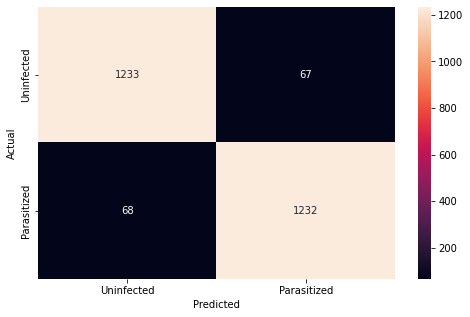

In [79]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred7 = model7.predict(new_gray_test)
pred7 = np.argmax(pred7,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred7))

#Plotting the heatmap using confusion matrix
cm7 = confusion_matrix(y_true,pred7)
plt.figure(figsize=(8,5))
sns.heatmap(cm7, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

###<b> Observations and Conclusions drawn from the grayscale model: 

Our results improved because we see better a better recall score for our second class. This means that we have a fewer number of errors on instances that we predict to be uninfected who actually are infected. 

We will now try with HSV

In [80]:
import cv2
gfx_3=[]   # to hold the HSV image array
for i in np.arange(0,24958,1):
  a=cv2.cvtColor(train_images[i],cv2.COLOR_BGR2HSV)
  gfx_3.append(a)
gfx_3=np.array(gfx_3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


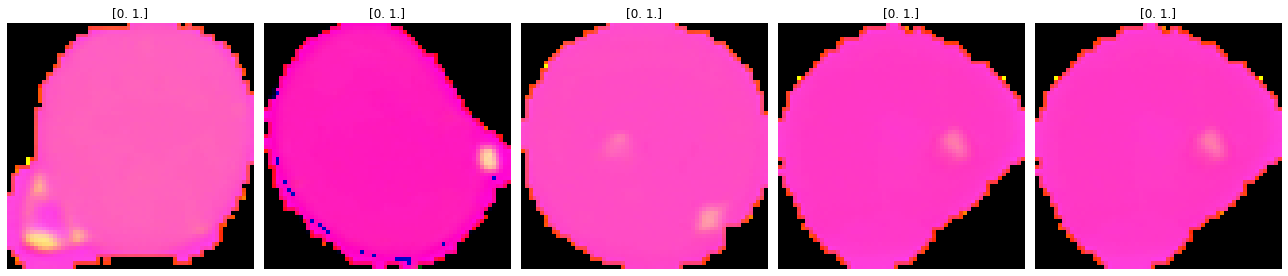

In [81]:
viewimage=np.random.randint(1,100,5)
fig,ax=plt.subplots(1,5,figsize=(18,18))
for t,i in zip(range(5),viewimage):
  Title=train_labels[i]
  ax[t].set_title(Title)
  ax[t].imshow(gfx_3[i])
  ax[t].set_axis_off()
  fig.tight_layout()

In [82]:
import cv2
gfx_4=[]   # to hold the HSV image array
for i in np.arange(0,2600,1):
  a=cv2.cvtColor(test_images[i],cv2.COLOR_BGR2HSV)
  gfx_4.append(a)
gfx_4=np.array(gfx_4)

In [83]:
gfx_3[0].shape

(64, 64, 3)

Feeding the HSV images to our model: 

In [84]:
model8=Sequential()
model8.add(Conv2D(filters=160,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model8.add(MaxPooling2D(pool_size=2))
model8.add(Dropout(0.2))
model8.add(Conv2D(filters=160,kernel_size=2,padding="same",activation="relu"))
model8.add(MaxPooling2D(pool_size=2))
model8.add(Dropout(0.2))
model8.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))
model8.add(MaxPooling2D(pool_size=2))
model8.add(Dropout(0.2))
model8.add(Conv2D(filters=224,kernel_size=2,padding="same",activation="relu")) #adding a 4th layer
model8.add(MaxPooling2D(pool_size=2))
model8.add(Dropout(0.2))


model8.add(Flatten())

model8.add(Dense(512,activation="relu"))
model8.add(Dropout(0.4))
model8.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model8.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 64, 160)       2080      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 160)       0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 32, 32, 160)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 160)       102560    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 160)       0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 160)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 128)      

####<b> Compiling the model

In [85]:
model8.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<b> Using Callbacks

In [86]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fit and Train the model

In [87]:
history8=model8.fit(gfx_3,train_labels,batch_size=32,callbacks=callbacks,  validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
624/624 [==============================] - 31s 48ms/step - loss: 0.9998 - accuracy: 0.6216 - val_loss: 0.8050 - val_accuracy: 0.1194
Epoch 2/20
624/624 [==============================] - 30s 48ms/step - loss: 0.6492 - accuracy: 0.6385 - val_loss: 0.9404 - val_accuracy: 0.1440
Epoch 3/20
624/624 [==============================] - 30s 48ms/step - loss: 0.6398 - accuracy: 0.6508 - val_loss: 0.8094 - val_accuracy: 0.1520


####<b> Evaluating the model

In [88]:
accuracy8 = model8.evaluate(gfx_4, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy7[1])

82/82 [==============================] - 2s 18ms/step - loss: 0.6685 - accuracy: 0.5612

 Test_Accuracy:- 0.9480769038200378


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.82      0.16      0.26      1300
           1       0.53      0.96      0.69      1300

    accuracy                           0.56      2600
   macro avg       0.68      0.56      0.48      2600
weighted avg       0.68      0.56      0.48      2600



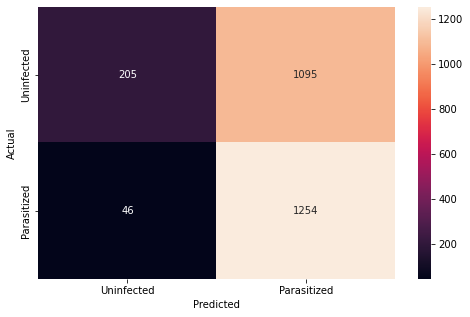

In [89]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred8 = model8.predict(gfx_4)
pred8 = np.argmax(pred8,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred8))

#Plotting the heatmap using confusion matrix
cm8 = confusion_matrix(y_true,pred8)
plt.figure(figsize=(8,5))
sns.heatmap(cm8, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b> Plotting the Train and validation curves

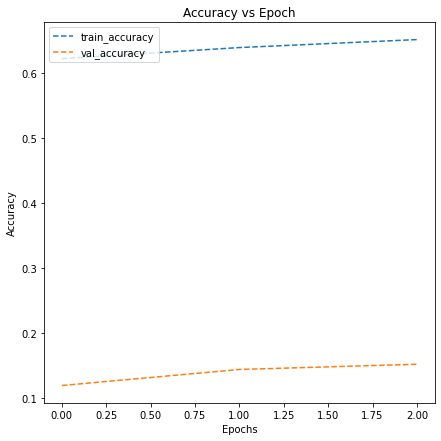

In [90]:
plot_accuracy(history8)

###<b> Observations and Conclusions drawn from the HSV model: 

* Our results significantly worsened after converting our images to HSV, so we will be sticking with grayscale

###<b> Observations and Conclusions drawn from the final model: 

* Our final model contains the hyperparameters, layers, and image modifications that provided the best recall performance which is what we were looking for. 

* This is because we got the lowest number of cases where we misclassified an infected cell as uninfected, which is the measure that we are trying to minimize. 

* The reason we want to minimize this number is because misclassifying an uninfected cell as infected isn't a strong worry because there is no harm, however misclassifying an infected cell as infected is dangerous because the cell would get more and more infected and can lead to a state beyond treatment. 



**Improvements that can be done:**<br>


*  In this study, we used one pre-trained model which did not improve our performance. However, we can try using other pre-trained models such as ResNet and see it how it performs on our data. 

*  Despite not seeing improvement with augmented images or HSV conversion, we did see a positive effect from grayscaling our images. This could mean that other possible transformations can potentially further increase our performance. We can use the opencv library to see other transformations available or try other methods of image augmentation. 

###<b>Insights

**1.**  What are the most meaningful insights from the data relevant to the problem?

* The data showed us that we need to train a model that can accurately distinguish between the features of uninfected and infected cells. This could either be done by pre processing the images with transformations, by tuning the hyperparameters of our model, or a combination of both. 

**2.  Comparison of various techniques and their relative performance:** How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

* Across all our models, we found that model1 performed the best, which we later hypertuned using keras tuner. We further improved performance by grayscaling the images which allowed our model to more accurately identify infected cells and minimize the number of infected cells classified as uninfected. Techniques such as batchnormalization, changing the activation function to LeakyRelU, pre-trained model, and our image augmentation did not lead to improvement. Converting to HSV lead to a significant decrease in performance wheras converting to grayscale allowed our optimal model to perform even better. 

**3.  Proposal for the final solution design:** What model do you propose to be adopted? Why is this the best solution to adopt?

* Given that our hyperparameter tuned model with grayscale input performed the best, I propose to move forward with this model. We want to minimize the risk of allowing our infected cells to worsen, thus we want the model that will have the least error when identifying infected cells. 

**4.  Key recommendations for implementation:** What are some key recommendations to implement the solutions? What should the implementation roadmap look like? What further analysis needs to be done or what other associated problems need to be solved?

* Implementing the solution should be done with a careful focus on the recall performance measure on infected cells. A lower digit of misclassified infected cells is the right direction, thus we should try different combinations of layers and techniques such as dropout and batch normalization to get this number as lowe as possible. We can also try using the keras tuner for other hyperparameters, or we can also use cross validation to further improve results. We also noticed that none of our models, despite a heavy amount of tuning reach above 95% accuracy. If we want to continue increasing the accuracy, we might want to try gathering more data or fixing misclassified labels if there are any. We can also try different types of image modification to see if our model performs better on them. 